##Importing the required modules

In [1]:
from google.colab import  drive
drive.mount('./gdrive')
%cd '/content/gdrive/MyDrive/EVA S9/EVA/S9/QuizDNN'

Mounted at ./gdrive
/content/gdrive/MyDrive/EVA S9/EVA/S9


In [25]:
from datetime import datetime 
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import StepLR

In [28]:
print("Current Date/Time: ", datetime.now())

Current Date/Time:  2021-02-06 17:50:15.037783


In [3]:
from utils import DataProcessing
from regularizations import Regularizations
from model import *
from graphs import Graphs
from train import *
from test import *
from QuizDNN import DNN



## Maintaining Reproducability

In [4]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

##Loading the Dataset, performing image transformations and loading the DataLoader

In [5]:
data = DataProcessing('CIFAR10')


In [6]:
train_set = data.Dataset('./Data', True, True, transforms.ToTensor())
test_set = data.Dataset('./Data', False, True, transforms.ToTensor())


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
data.Transform(train_set, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.RandomHorizontalFlip())
data.Transform(test_set, transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), transforms.RandomHorizontalFlip())

In [9]:
train_loader = data.DataLoader(train_set, 100, shuffle=True, num_workers=4, pin_memory=True)
test_loader = data.DataLoader(test_set, 100, shuffle=True, num_workers=4, pin_memory=True)

## Taking a sneak peek at the dataset

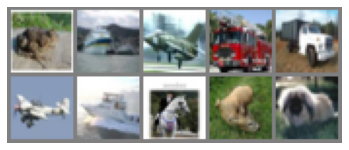

['frog', 'ship', 'airplane', 'truck', 'truck', 'airplane', 'ship', 'horse', 'deer', 'dog']


In [10]:
batch = next(iter(train_loader))
images, labels = batch
image, label = [], []
for index in range(10):
  image.append(images[index])
  label.append(train_set.classes[labels[index].item()])
grid = torchvision.utils.make_grid(image, nrow=5)
plt.imshow(np.transpose(grid/2 + 0.5,(1,2,0)))
plt.axis('off')
plt.show()
print(label)


## Viewing the parameter count used in the model

In [20]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available() # check if GPU available
device = torch.device("cuda" if use_cuda else "cpu") # use cpu if gpu is not available
model = DNN().to(device) 
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
              ReLU-2           [-1, 64, 32, 32]               0
       BatchNorm2d-3           [-1, 64, 32, 32]             128
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
             ReLU-10           [-1, 64, 32, 32]               0
      BatchNorm2d-11           [-1, 64, 32, 32]             128
          Dropout-12           [-1, 64, 32, 32]               0
        MaxPool2d-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

##Loading the object for different regularizations

In [21]:
regularizer = Regularizations('SGD', model, 0.01, 0.9, 6, 0.1)

## Defining the main sequence of training and testing the model using the imported modules

In [22]:
def run(epochs, model, device, train_loader, regularizer, test_set, test_loader):
  train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
  wrong_pred_data={'Images':[], 'Predicted':[], 'Actual':[]}
  last_epoch = False
  for epoch in range(epochs):
    print(f"Epoch {epoch+1} in progress....")
    train_loss, train_accuracy = train_model(model, device, train_loader, regularizer)
    if epoch == epochs - 1:
      last_epoch = True        
    test_loss, test_accuracy = test_model(model, device, test_set, test_loader, regularizer, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'], last_epoch)
    print(f"\nEpoch : {epoch+1} \n\nAverage Train Loss : {train_loss :.9f} \nTrain Accuracy : {train_accuracy : .4f}% \n\nAverage Test Loss : {test_loss :.9f} \nTest Accuracy : {test_accuracy : .4f}% \n\n")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    regularizer.optimizer_step(step=True)
  return train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data

## Logging the results

In [23]:
train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data = run(25, model, device, train_loader, regularizer, test_set, test_loader)

Epoch 1 in progress....

Epoch : 1 

Average Train Loss : 0.013379295 
Train Accuracy :  51.3260% 

Average Test Loss : 0.010804065 
Test Accuracy :  61.5600% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.009225017 
Train Accuracy :  67.4040% 

Average Test Loss : 0.009358495 
Test Accuracy :  66.9900% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.007507210 
Train Accuracy :  73.7580% 

Average Test Loss : 0.007515606 
Test Accuracy :  73.4700% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.006422297 
Train Accuracy :  77.6380% 

Average Test Loss : 0.006543947 
Test Accuracy :  76.9000% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.005635202 
Train Accuracy :  80.4040% 

Average Test Loss : 0.006114770 
Test Accuracy :  78.4900% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.005167686 
Train Accuracy :  82.1860% 

Average Test Loss : 0.006497714 
Test Accuracy :  77.3900% 


Epoch 7 in progress....

Epo

## Plotting the graph for the logged results

In [ ]:
graphs = Graphs('Validation Loss', 'Validation Accuracy')


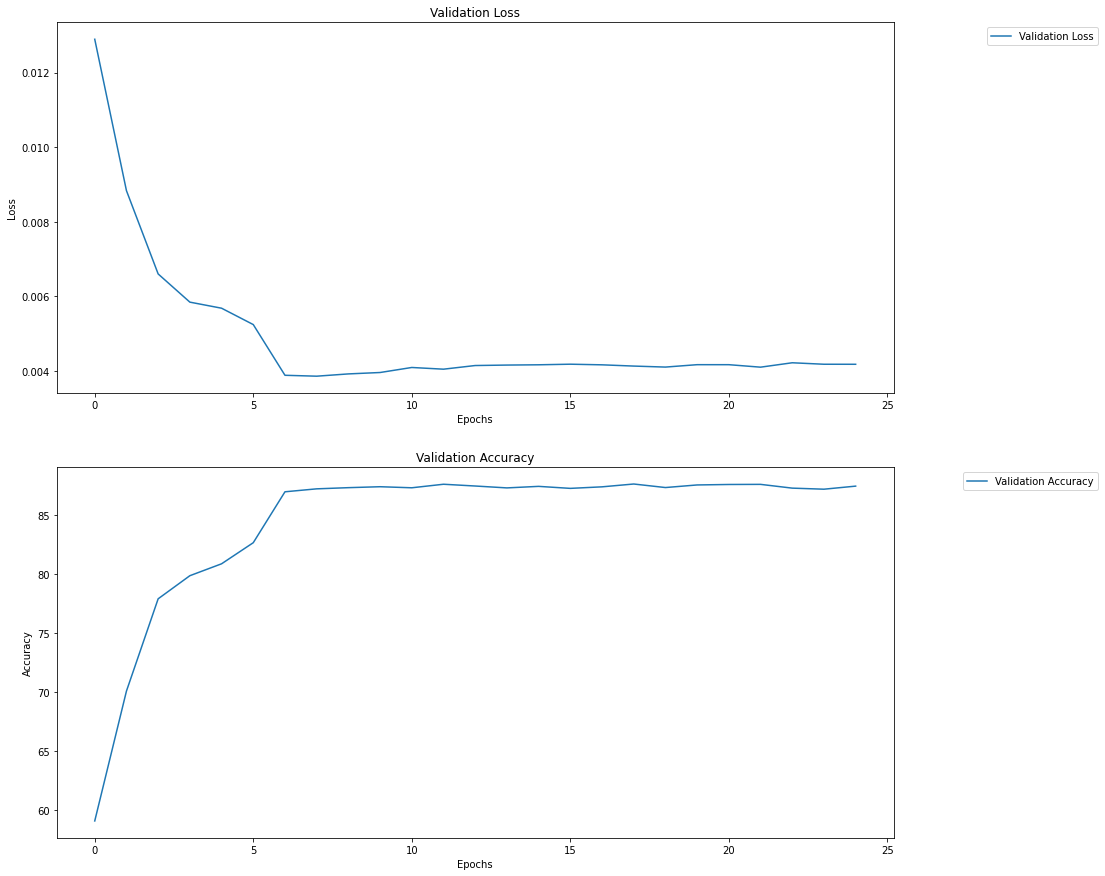

In [ ]:
graphs.line_graph((15,15), test_losses, test_accuracies)


## Plotting 25 Misclassified Predictions

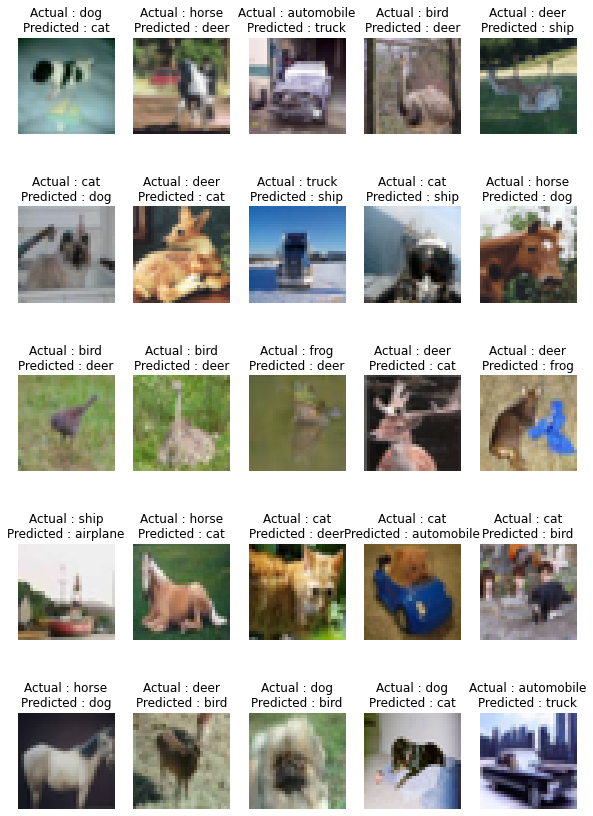

In [ ]:
graphs.image_graph(5, 5, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'])